In [1]:
#------ Prologue
import postgkyl as pg
import numpy as np
#import pylab as plt
#import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)
import matplotlib.cm as cm
import os, fnmatch, re, sys
#------ add personnal python utilities
home_dir = os.path.expanduser("~")
sys.path.append(home_dir+'/personal_gkyl_scripts/python_utilities')
from classes import Simulation, Species, GBsource
from utils import *
#----- some parameters of the simulation
#----- physical quantities
simulation = Simulation()
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = 1.45,                 # Elongation factor
    delta       = 0.35,                 # Triangularity factor
    q0          = None,                 # Safety factor
    x_LCFS      = 0.04                  # position of the LCFS (x_inner)
)

simulation.set_data_param(
    expdatadir ='/home/ah1032/amd/g0_sim/diagnostics/gk_tcv/tcv_exp_data/',
    g0simdir   = home_dir+'/g0_sim/',
    simname    = '48x32x16x16x6_nunifvg',
    simdir     = 'gk_tcv_posD_iwl_3x2v_AH/',
    fileprefix = 'gk_tcv_posD_iwl_3x2v_D02',
    wkdir      = 'wk/'
)

# Load metric coefficients, magnetic field
simulation.geom_param.load_metric(simulation.data_param.fileprefix)

# Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
simulation.add_species(ion)
simulation.add_species(elc)
# Check available frames
tfs = find_available_frames(simulation,'field')
print(tfs)
#--------- Set up some normalizations for the plots
#-- Time scale
simulation.set_normalization(key='t',scale=1e-6,shift=0,symbol='t',units=r'$\mu s$')
#-- Radial length
# Lref   = simulation.species['ion'].rho; xshift = 0; xsymbol = r'$x/\rho_s$'; xunits = ''
Lref   = 1.0; xshift = simulation.geom_param.x_LCFS; xsymbol = r'$R-R_{LCFS}$'; xunits = 'm'
simulation.set_normalization(key='x',scale=Lref,shift=xshift,symbol=xsymbol,units=xunits)
#-- Poloidal length
Lref   = simulation.species['ion'].rho
yshift = 0
ysymbol= r'$y/\rho_s$'
yunits = ''
simulation.set_normalization(key='y',scale=Lref,shift=0,symbol=ysymbol,units=yunits)
#-- Temperature normalization
Tref_i = simulation.phys_param.eV/simulation.species['ion'].m
Tref_e = simulation.phys_param.eV/simulation.species['elc'].m
simulation.set_normalization(key='upare', scale=elc.vt,shift=0,symbol=r'$u_{\parallel e}/v_{te}$',units='')
simulation.set_normalization(key='upari', scale=ion.vt,shift=0,symbol=r'$u_{\parallel i}/v_{ti}$',units='')
simulation.set_normalization(key='Tpare', scale=Tref_e,shift=0,symbol=r'$T_{\parallel e}$',units='eV')
simulation.set_normalization(key='Tpari', scale=Tref_i,shift=0,symbol=r'$T_{\parallel i}$',units='eV')
simulation.set_normalization(key='Tperpe',scale=Tref_e,shift=0,symbol=r'$T_{\perp e}$',units='eV')
simulation.set_normalization(key='Tperpi',scale=Tref_i,shift=0,symbol=r'$T_{\perp i}$',units='eV')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [2]:
#---- Compute particle loss due to fluctuations over time in the simulation
from classes import Frame

#---- Evaluate the particle input from the numerical gradB source
simulation.set_GBsource(    
    n_srcGB     = 3.185e23,
    T_srcGB     = 100*simulation.phys_param.eV,
    x_srcGB     = 0,
    sigma_srcGB = 10*simulation.get_rho_s(),
    bfac_srcGB  = 1.4,
    temp_model  = 'constant',
    dens_model  = 'singaus'
)

twindow = tfs
GBloss_i_t, time = simulation.GBsource.get_GBloss_t(
    sim=simulation,
    species=ion,
    twindow=twindow,
    ix=0)

GBloss_e_t, time = simulation.GBsource.get_GBloss_t(
    sim=simulation,
    species=elc,
    twindow=twindow,
    ix=0)

# Evaluate the artificial gradB source
GBs_z   = [simulation.GBsource.dens_source(0,z_) for z_ in simulation.geom_param.z]
GBs_tot = np.trapz(GBs_z,x=simulation.geom_param.z,axis=0)
GBsrc_t   = [GBs_tot for t_ in time]


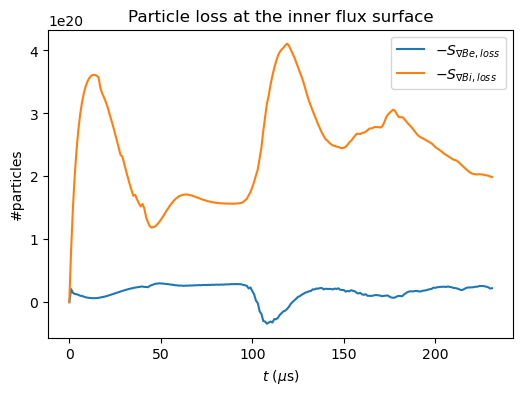

In [3]:
#--- Compare the source and loss along time
plt.plot(time,[-g for g in GBloss_e_t],label=r'$-S_{\nabla B e, loss}$')
plt.plot(time,[-g for g in GBloss_i_t],label=r'$-S_{\nabla B i, loss}$')
# plt.plot(time,np.abs(GBsrc_t),label=r'$|S_{\nabla B, source}|$',color='black',linestyle='--')
plt.ylabel(r'#particles')
plt.xlabel(r'$t$ ($\mu$s)')
plt.title('Particle loss at the inner flux surface')
# plt.yscale('log')
plt.legend()